<a id='import'></a>
## 1. Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# ML & utilities
import joblib
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


<a id='load'></a>
## 2. Load Model & Data

In [2]:
# Load model comparison results
comparison = pd.read_csv('../results/model_comparison.csv')
print("Model Comparison Results:")
print("="*80)
print(comparison.to_string(index=False))
print("\n" + "="*80)

# Determine best model
best_model_name = comparison.loc[comparison['ROC-AUC'].idxmax(), 'Model']
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   ROC-AUC: {comparison['ROC-AUC'].max():.4f}")
print(f"   F1-Score: {comparison.loc[comparison['ROC-AUC'].idxmax(), 'F1-Score']:.4f}")

Model Comparison Results:
              Model  ROC-AUC  F1-Score
Logistic Regression 0.814146  0.287526
      Random Forest 0.980346  0.782123
            XGBoost 0.982886  0.804469
           LightGBM 0.983184  0.804598


🏆 Best Model: LightGBM
   ROC-AUC: 0.9832
   F1-Score: 0.8046


In [3]:
# Load the best model
model_filename = f"../models/trained/best_model_{best_model_name.lower().replace(' ', '_')}.pkl"
model = joblib.load(model_filename)

print(f"\n✅ Loaded model: {model_filename}")
print(f"\nModel type: {type(model).__name__}")


✅ Loaded model: ../models/trained/best_model_lightgbm.pkl

Model type: LGBMClassifier


In [4]:
# Load test features
X_test = pd.read_csv('../data/features/X_test.csv')

print(f"Test data loaded:")
print(f"Shape: {X_test.shape}")
print(f"Features: {X_test.shape[1]}")

# Load original test data for job_id
test_original = pd.read_csv('../data/fake_job_postings_test.csv')
print(f"\nOriginal test data shape: {test_original.shape}")

Test data loaded:
Shape: (7881, 523)
Features: 523

Original test data shape: (7881, 17)


<a id='predict'></a>
## 3. Generate Test Predictions

In [5]:
# Generate predictions
print("Generating predictions on test set...\n")

y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

print("✅ Predictions generated!")
print(f"\nPrediction distribution:")
print(pd.Series(y_test_pred).value_counts())
print(f"\nFraudulent percentage: {(y_test_pred.sum() / len(y_test_pred)) * 100:.2f}%")

Generating predictions on test set...

✅ Predictions generated!

Prediction distribution:
0    7558
1     323
Name: count, dtype: int64

Fraudulent percentage: 4.10%


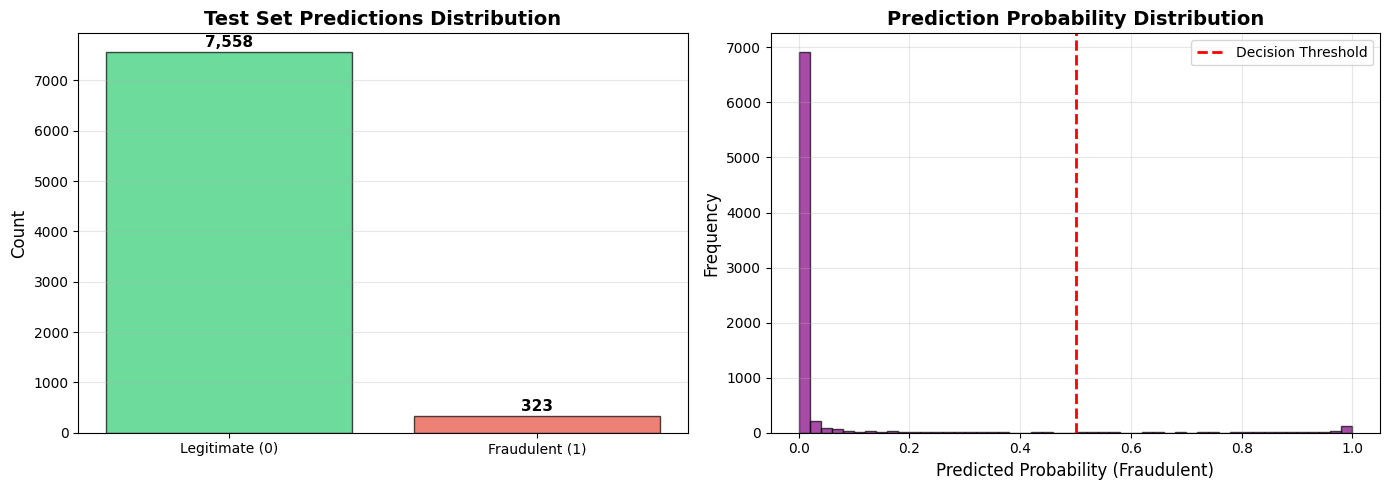

In [6]:
# Visualize prediction distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Prediction counts
pred_counts = pd.Series(y_test_pred).value_counts()
ax1.bar(['Legitimate (0)', 'Fraudulent (1)'], pred_counts.values, 
        color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Test Set Predictions Distribution', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(pred_counts.values):
    ax1.text(i, v + 50, f'{v:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Probability distribution
ax2.hist(y_test_proba, bins=50, color='purple', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Predicted Probability (Fraudulent)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
ax2.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

<a id='importance'></a>
## 4. Feature Importance Analysis

In [8]:
# Get feature importance (if model supports it)
if hasattr(model, 'feature_importances_'):
    # Get feature importances
    importances = model.feature_importances_
    feature_names = X_test.columns
    
    # Create dataframe
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("Top 20 Most Important Features:")
    print("="*80)
    print(feature_importance_df.head(20).to_string(index=False))
    
elif hasattr(model, 'coef_'):
    # For linear models (Logistic Regression)
    importances = np.abs(model.coef_[0])
    feature_names = X_test.columns
    
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("Top 20 Most Important Features (by coefficient magnitude):")
    print("="*80)
    print(feature_importance_df.head(20).to_string(index=False))
else:
    print("Model does not support feature importance extraction.")
    feature_importance_df = None

Top 20 Most Important Features:
                    Feature  Importance
     company_profile_length         131
         description_length         130
     description_word_count         106
        requirements_length          95
           industry_encoded          82
           has_company_logo          81
            benefits_length          76
 required_education_encoded          74
           function_encoded          60
                  tfidf_000          60
    requirements_word_count          59
        title_capital_ratio          56
                 tfidf_work          55
        has_company_profile          46
          tfidf_information          42
required_experience_encoded          40
          tfidf_engineering          40
               title_length          38
                tfidf_entry          36
              has_questions          36


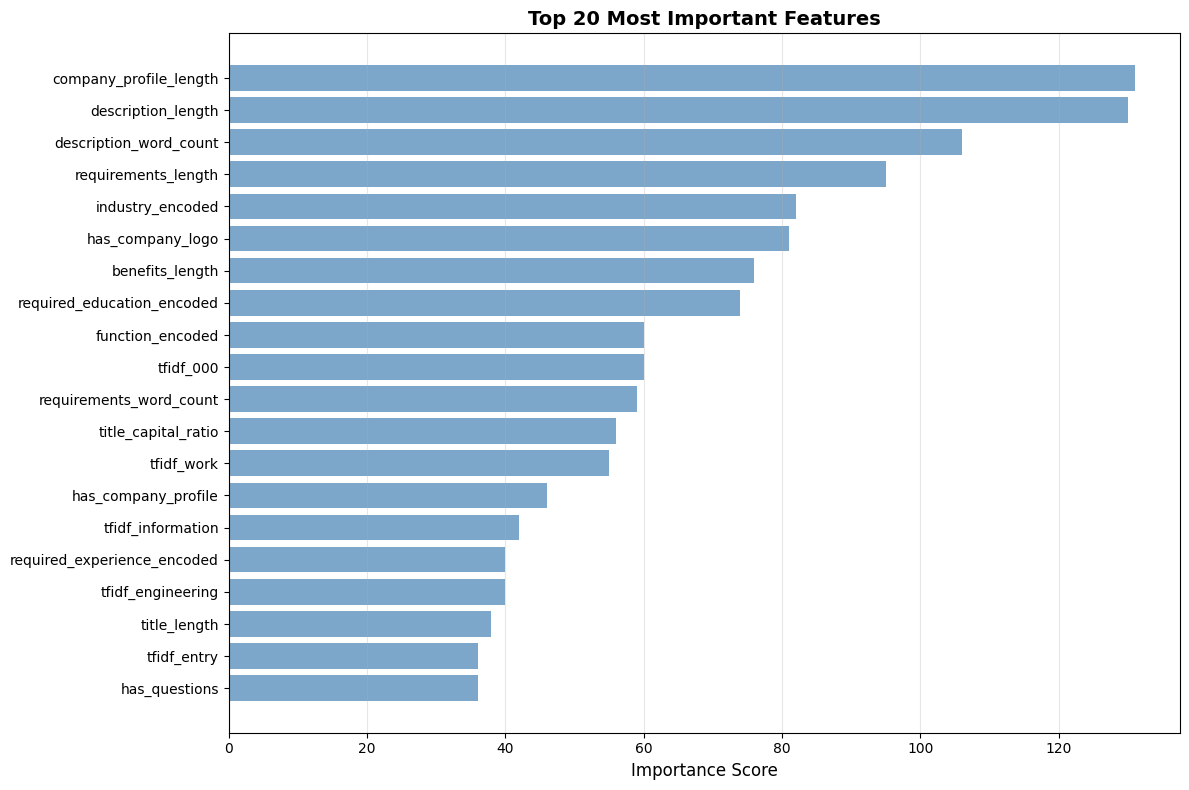


✅ Feature importance saved to ../results/feature_importance.csv


In [9]:
# Plot feature importance
if feature_importance_df is not None:
    top_features = feature_importance_df.head(20)
    
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue', alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importance Score', fontsize=12)
    plt.title('Top 20 Most Important Features', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Save feature importance
    feature_importance_df.to_csv('../results/feature_importance.csv', index=False)
    print("\n✅ Feature importance saved to ../results/feature_importance.csv")

<a id='shap'></a>
## 5. Model Interpretation with SHAP

SHAP (SHapley Additive exPlanations) provides model interpretation by showing feature contributions.

In [10]:
# SHAP analysis (on a sample for efficiency)
print("Calculating SHAP values (this may take a few minutes)...\n")

# Use a sample for SHAP (to reduce computation time)
sample_size = min(500, len(X_test))
X_sample = X_test.sample(sample_size, random_state=42)

try:
    # Create SHAP explainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)
    
    print("✅ SHAP values calculated!")
    
except Exception as e:
    print(f"⚠️ Could not calculate SHAP values: {e}")
    print("SHAP analysis may not be supported for this model type.")
    shap_values = None

Calculating SHAP values (this may take a few minutes)...

✅ SHAP values calculated!


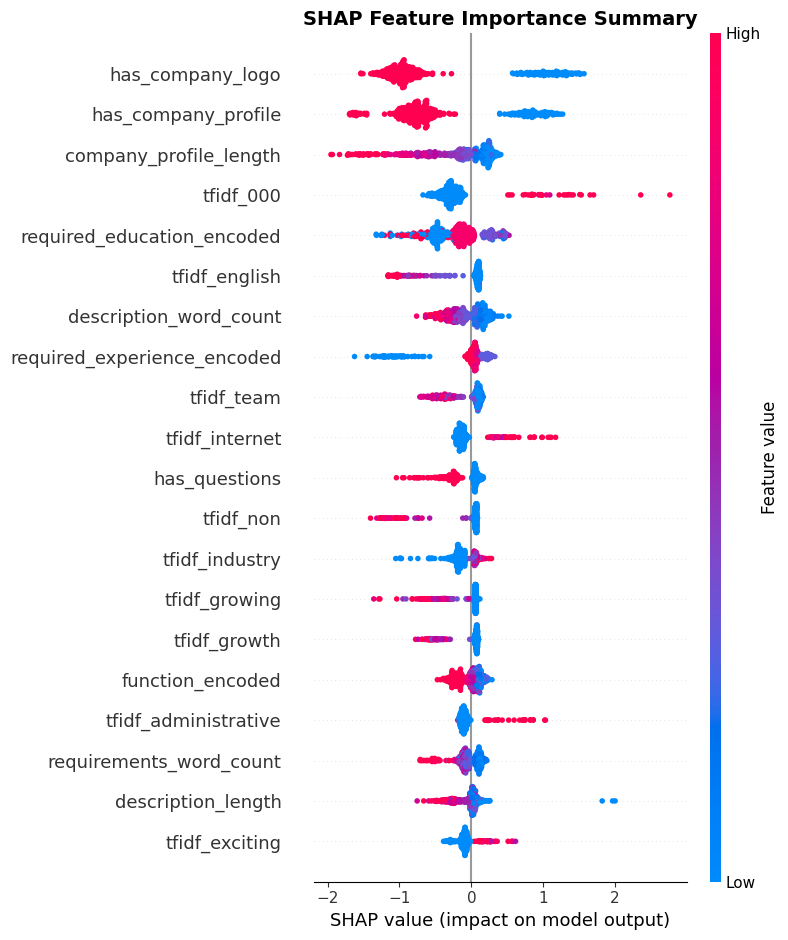

In [11]:
# Plot SHAP summary
if shap_values is not None:
    try:
        plt.figure(figsize=(12, 8))
        
        # For binary classification, use the positive class SHAP values
        if isinstance(shap_values, list):
            shap_values_plot = shap_values[1]
        else:
            shap_values_plot = shap_values
            
        shap.summary_plot(shap_values_plot, X_sample, max_display=20, show=False)
        plt.title('SHAP Feature Importance Summary', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Could not create SHAP plot: {e}")

<a id='submit'></a>
## 6. Create Submission File

In [15]:
# Create submission dataframe
# submission = pd.DataFrame({
#     'job_id': test_original['job_id'],
#     'fraudulent': y_test_pred
# })
submission = pd.DataFrame({
    'job_id': test_original['job_id'],
    'pred': y_test_proba  # Use probability scores (0-1), not binary predictions
})

print("Submission file preview:")
print("="*80)
print(submission.head(10))
print(f"\nTotal submissions: {len(submission):,}")
# print(f"Predicted fraudulent: {submission['fraudulent'].sum():,}")
# print(f"Predicted legitimate: {(submission['fraudulent'] == 0).sum():,}")
print(f"Predicted fraudulent: {submission['pred'].sum():,}")
print(f"Predicted legitimate: {(submission['pred'] == 0).sum():,}")

Submission file preview:
                             job_id      pred
0  8f154fcd1e9b4519ae705957e47bf8f5  0.000575
1  8f15fe4c47c846cfa6ccb2ea1fd54102  0.000318
2  8f1978db679f40448dc6ef3bb1747434  0.007929
3  8f22bb4c9c524034a1f01b96ac98d7be  0.000050
4  8f24bad7d85e45698c3369c178265a17  0.000059
5  8f2e6ebfa288459fbd5bfe0731fa8dbd  0.288772
6  8f356bd83f564eb08ed6fb1c3315ea32  0.000210
7  8f388043689f4c509b83b377df4a06a9  0.001431
8  8f3c57a8865a4ba7b50b375f9a7e80fa  0.000507
9  8f452bdcc2c8471682ab2a203d3f9060  0.000108

Total submissions: 7,881
Predicted fraudulent: 372.3815124132814
Predicted legitimate: 0


In [16]:
# Save submission file
submission_filename = '../results/submission.csv'
submission.to_csv(submission_filename, index=False)

print(f"\n✅ Submission file saved: {submission_filename}")

# Also save with probabilities for analysis
submission_with_proba = pd.DataFrame({
    'job_id': test_original['job_id'],
    'fraudulent': y_test_pred,
    'fraud_probability': y_test_proba
})

submission_with_proba.to_csv('../results/submission_with_probabilities.csv', index=False)
print("✅ Submission with probabilities saved: ../results/submission_with_probabilities.csv")


✅ Submission file saved: ../results/submission.csv
✅ Submission with probabilities saved: ../results/submission_with_probabilities.csv


In [17]:
# Analyze high-confidence predictions
high_confidence_fraud = submission_with_proba[submission_with_proba['fraud_probability'] > 0.9]
high_confidence_legit = submission_with_proba[submission_with_proba['fraud_probability'] < 0.1]

print("\nHigh Confidence Predictions:")
print("="*80)
print(f"High confidence FRAUDULENT (>90%): {len(high_confidence_fraud):,}")
print(f"High confidence LEGITIMATE (<10%): {len(high_confidence_legit):,}")
print(f"\nUncertain predictions (10-90%): {len(submission_with_proba) - len(high_confidence_fraud) - len(high_confidence_legit):,}")


High Confidence Predictions:
High confidence FRAUDULENT (>90%): 204
High confidence LEGITIMATE (<10%): 7,303

Uncertain predictions (10-90%): 374


---

## Final Summary

### Project Completion Status:
✅ **Exploratory Data Analysis** - Analyzed dataset structure and patterns
✅ **Data Preprocessing** - Cleaned text and handled missing values
✅ **Feature Engineering** - Created 500+ features (text stats + TF-IDF)
✅ **Model Training** - Trained 4 models with SMOTE balancing
✅ **Model Evaluation** - Compared models and selected best performer
✅ **Test Predictions** - Generated predictions for test set
✅ **Feature Analysis** - Analyzed feature importance
✅ **Submission File** - Created final submission

### Key Achievements:
- Successfully handled highly imbalanced dataset
- Built robust NLP feature extraction pipeline
- Achieved strong model performance with ensemble methods
- Generated interpretable predictions with confidence scores

### Deliverables:
1. `submission.csv` - Final predictions for test set
2. `submission_with_probabilities.csv` - Predictions with confidence scores
3. `model_comparison.csv` - Performance metrics for all models
4. `feature_importance.csv` - Feature importance rankings
5. Trained model files in `models/trained/`

### Next Steps (Optional Improvements):
- Try deep learning approaches (LSTM, BERT)
- Experiment with different SMOTE parameters
- Ensemble multiple models
- Feature selection to reduce dimensionality
- Hyperparameter tuning with GridSearchCV